# Linear Regression

This notebook demonstrates how to use `rice_ml.supervised_learning.linear_regression.LinearRegression`
to fit a regression model on a real dataset.

We will:
1. Load a standard regression dataset (Diabetes).
2. Standardize features (important for gradient descent stability).
3. Fit OLS and Ridge models (closed-form solver).
4. Fit a Gradient Descent (GD) version.
5. Evaluate results using RMSE and R², and visualize predictions.



In [21]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def add_repo_src_to_path(max_up: int = 8) -> None:
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package.")

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize
from rice_ml.supervised_learning.linear_regression import LinearRegression

np.random.seed(42)


## 2. Load a regression dataset

We use the Diabetes dataset (10 features, target is a quantitative disease progression measure).
This dataset is small but realistic, and is commonly used for regression demos.


In [6]:
try:
    from sklearn.datasets import load_diabetes
    from sklearn.model_selection import train_test_split
except Exception as e:
    raise ImportError("This notebook needs scikit-learn installed (for datasets/splitting).") from e

data = load_diabetes()
X = data.data
y = data.target
feature_names = list(data.feature_names)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", feature_names[:])


X shape: (442, 10)
y shape: (442,)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


## 3. Train/test split and standardization

We standardize features using training statistics only (mean/std from train),
then apply the same transform to the test split. This is especially important
for gradient descent and for comparing coefficients across features.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Ensure arrays are numpy arrays (safe casting)
X_train = np.asarray(X_train, dtype=float)
X_test  = np.asarray(X_test, dtype=float)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)


# 2) Fit standardization params on TRAIN set only
X_train_std, params = standardize(X_train, return_params=True)

# NOTE: your standardize returns params dict with keys: "mean" and "scale"
mean = params["mean"]
scale = params["scale"]  # scale is std with zeros replaced by 1.0

# 3) Apply same params to TEST set (no leakage)
X_test_std = (X_test - mean) / scale

# 4) Quick sanity checks
print("  Train mean (approx):", X_train_std.mean(axis=0)[:5])
print("  Train std  (approx):", X_train_std.std(axis=0)[:5])
print("  Test  mean (approx):", X_test_std.mean(axis=0)[:5])
print("  Test  std  (approx):", X_test_std.std(axis=0)[:5])


  Train mean (approx): [ 2.76769479e-17  9.12081238e-17 -6.69907944e-17  3.33381418e-17
 -2.67334156e-17]
  Train std  (approx): [1. 1. 1. 1. 1.]
  Test  mean (approx): [-0.15475875 -0.0191956  -0.18259061 -0.1210162   0.0578151 ]
  Test  std  (approx): [1.12390087 0.99867091 1.02408276 0.90468304 0.98262382]


## 4. Fit OLS (closed-form)

We first fit ordinary least squares with the closed-form solver.
We report:
- RMSE on test set
- R² on test set


In [16]:
ols = LinearRegression(fit_intercept=True, solver="normal", l2=0.0)
ols.fit(X_train_std, y_train)

y_pred_ols = ols.predict(X_test_std)
rmse_ols = float(np.sqrt(np.mean((y_test - y_pred_ols) ** 2)))
r2_ols = ols.score(X_test_std, y_test)

print("OLS:")
print("  RMSE:", rmse_ols)
print("  R^2:", r2_ols)
print("  coef_ shape:", np.asarray(ols.coef_).shape)
print("  intercept_:", ols.intercept_)


OLS:
  RMSE: 53.85344583676592
  R^2: 0.4526027629719196
  coef_ shape: (10,)
  intercept_: 153.73654390934846


## 5. Fit Ridge (L2 regularization)

Ridge adds an L2 penalty to reduce coefficient magnitude and improve numerical stability.
This can help when features are correlated or the design matrix is ill-conditioned.

Note: the intercept is not regularized.


In [17]:
ridge = LinearRegression(fit_intercept=True, solver="normal", l2=1.0)
ridge.fit(X_train_std, y_train)

y_pred_ridge = ridge.predict(X_test_std)
rmse_ridge = float(np.sqrt(np.mean((y_test - y_pred_ridge) ** 2)))
r2_ridge = ridge.score(X_test_std, y_test)

print("Ridge (l2=1.0):")
print("  RMSE:", rmse_ridge)
print("  R^2:", r2_ridge)
print("  L2 norm of coef (OLS):  ", float(np.linalg.norm(ols.coef_)))
print("  L2 norm of coef (Ridge):", float(np.linalg.norm(ridge.coef_)))


Ridge (l2=1.0):
  RMSE: 53.77745406534389
  R^2: 0.45414652070698236
  L2 norm of coef (OLS):   71.62969045094266
  L2 norm of coef (Ridge): 60.908845285422515


## 6. Gradient Descent solver

This step uses the same objective (OLS or Ridge) but optimizes with batch gradient descent.
It is useful to demonstrate optimization behavior and why standardization matters.

We also plot the loss curve to confirm convergence.


In [18]:
gd = LinearRegression(
    fit_intercept=True,
    solver="gd",
    l2=0.0,
    lr=0.2,
    max_iter=8000,
    tol=1e-12,
)
gd.fit(X_train_std, y_train)

y_pred_gd = gd.predict(X_test_std)
rmse_gd = float(np.sqrt(np.mean((y_test - y_pred_gd) ** 2)))
r2_gd = gd.score(X_test_std, y_test)

print("GD:")
print("  RMSE:", rmse_gd)
print("  R^2:", r2_gd)
print("  n_iter_:", gd.n_iter_)


GD:
  RMSE: 53.85339568355096
  R^2: 0.4526037825433913
  n_iter_: 4740


## 7. Visualization

A quick sanity check: plot predicted vs. true values on the test set.
If the model is reasonable, points should roughly align along the diagonal.


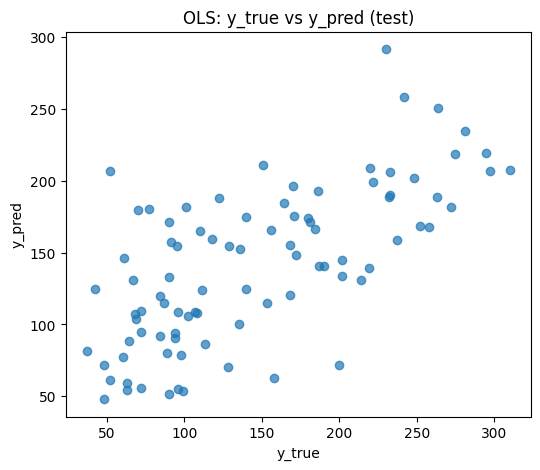

In [20]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_ols, alpha=0.7)
plt.title("OLS: y_true vs y_pred (test)")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.show()


## 8. Interpretation & Conclusion

We trained and evaluated three linear models:

- **OLS (closed-form)**  
  - RMSE ≈ **53.85**  
  - R² ≈ **0.453**

- **Ridge (L2 = 1.0)**  
  - RMSE ≈ **53.78**  
  - R² ≈ **0.454**  
  - Coefficient L2 norm shrinks from **71.63 (OLS)** to **60.91 (Ridge)**

- **Gradient Descent (GD)** (minimizing the same squared-loss objective)  
  - RMSE ≈ **53.85**  
  - R² ≈ **0.453**  
  - Converged in **~4740** iterations

- **OLS vs Ridge:**  
  OLS minimizes squared error without any coefficient penalty, while Ridge adds an L2 penalty that shrinks coefficients.  
  On datasets with correlated features or noisy targets, Ridge can improve stability and sometimes generalization.

- **Why standardize features:**  
  Standardization makes each feature comparable in scale. This is especially important for **gradient descent**, because large-scale features otherwise dominate the gradient and slow or destabilize convergence.

- **GD vs closed-form:**  
  The closed-form solver ("normal") is fast and exact for small/medium problems.  
  Gradient descent is iterative and may require tuning (`lr`, `tol`, `max_iter`), but it demonstrates optimization clearly and can be extended to large-scale settings.


- GD matches OLS almost exactly, which is a strong sign the GD implementation is correct and converged to the same optimum.  
- Ridge is slightly better here (small RMSE/R² improvement) and produces smaller-magnitude coefficients, reflecting its regularization effect.


On this dataset, all three approaches achieve similar predictive performance.  
- **OLS** provides a strong baseline with a direct closed-form solution.  
- **Ridge** adds mild regularization and slightly improves generalization while shrinking coefficients.  
- **GD** provides an optimization-based alternative that agrees with OLS when properly tuned and run long enough.

In practice, linear regression is a strong baseline. Even when the relationship is not perfectly linear, it provides a transparent reference point and interpretable coefficients.
